In [149]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
#A = trainNoCategories.as_matrix()
#U, s, V = np.linalg.svd(A, full_matrices=True)

In [3]:

tripTrain = pd.read_csv('data/trip_train.csv',
                   usecols=['duration', 'start_date', 'start_station_id', 'subscription_type'])
tripTest = pd.read_csv('data/trip_test.csv',
                   usecols=[ 'start_date', 'start_station_id', 'subscription_type'])
station = pd.read_csv('data/station.csv', usecols=['id','city'])
weather = pd.read_csv('data/weather.csv')

In [4]:
x = pd.read_csv('data/trip.csv',
                   usecols=['id','duration'])
tarjet = pd.read_csv('data/trip_test.csv',
                   usecols=[ 'id'])

In [5]:
testTarjet = pd.merge(x,tarjet, how = "inner", on = "id")
testTarjet.head()

,id,duration
0,4130,71
1,4498,126
2,4557,130
3,4386,134
4,4242,141


In [74]:
def preprocess(station, weather, trip):
    station = preprocessStation(station)
    weather = preprocessWeather(weather)
    trip = preprocessTrip(trip)
    trip = trip.merge(station, left_on='start_station_id', right_on='id')
    trip.drop('id', axis=1, inplace=True)
    trip = trip.merge(weather, left_on=['start_date', 'zip_code'], right_on=['date', 'zip_code'], how='outer')
    trip.drop(['date', 'zip_code'], axis=1, inplace=True)
    return encode(trip)
    
def preprocessStation(df):
    df = df.copy()
    df["zip_code"] = df.city.apply(zipCode)
    df.drop(labels=['city'], axis=1, inplace=True)
    return df

def preprocessTrip(df):
    df = df.copy()
    df['start_date'] = df['start_date'].apply(lambda x : pd.to_datetime(x))
    df['time'] = df.start_date.apply(lambda x: 60 * x.hour + x.minute)
    df['year'] = df.start_date.apply(lambda x : x.year)
    df['month'] = df.start_date.apply(lambda x : x.month)
    df['day'] = df.start_date.apply(lambda x : x.day)
    df['dayofweek'] = df.start_date.apply(lambda x : x.isoweekday())
    df['subscription_type'] = df.subscription_type.apply(lambda x: 1 if x == "Subscriber" else 0)
#    df = df.merge(holidays.to_frame(), left_on='start_date', right_on=holidays.to_frame().index, how='outer')
    return df

def preprocessWeather(df):
    df = df.copy()
    cleanPrecipitation(df)
    cleanEvents(df)
    df = df.fillna(0)
    df['date'] = df.date.apply(lambda x: pd.to_datetime(x).date())
    numberEvents(df)
    return df

def numberEvents(df):
    df['events'] = df.events.apply(eventNumber)

def eventNumber(eventString):
    if eventString == 'Normal': return 0
    elif eventString == 'Rain': return 1
    elif eventString == 'Fog': return 2
    elif eventString == 'Fog-Rain': return 3
    else: return 4

def zipCode(city):
    if city == 'San Francisco' : return 94107
    elif city == 'San Jose' : return 95113
    elif city == 'Redwood City' : return 94063
    elif city == 'Palo Alto' : return 94301
    elif city == 'Mountain View' : return 94041

def cleanPrecipitation(df):
    df.dropna(subset=["precipitation_inches"], inplace=True)
    df['precipitation_inches'] = df.precipitation_inches.apply(lambda x:
                                                               0.005 if (x == 'T')
                                                               else float(x))
def cleanEvents(df):
    df['events'] = df.events.apply(lambda x: "Normal" if pd.isnull(x) else x)
    df['events'] = df.events.apply(lambda x: "Rain" if x == "rain" else x)

def encode(df):
    encoder = sklearn.preprocessing.OneHotEncoder()
    return pd.DataFrame(encoder.fit_transform(df).toarray())

from pandas.tseries.holiday import USFederalHolidayCalendar as calendarUSFH
cal = calendarUSFH()
holidays = cal.holidays(return_name=True, start=pd.to_datetime('20130101'), end=pd.to_datetime('20151231'))

import sklearn.preprocessing

In [61]:
y = pd.read_csv('data/tripsWithWeather.csv')

In [62]:
y.head()

,date,id,duration,station,station_id,subscription_type,time,day_of_week,month,year,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees
0,2013-09-02,8808,827,Market at 4th,76,1,1236,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
1,2013-09-02,8589,27908,Market at 4th,76,1,951,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
2,2013-09-02,9352,610,Market at 4th,76,1,2206,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
3,2013-09-02,8988,7231,Market at 4th,76,1,1431,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0
4,2013-09-02,9354,12603,Market at 4th,76,1,2219,0,9,2013,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,Normal,277.0


In [63]:
y.dtypes

date                               object
id                                  int64
duration                            int64
station                            object
station_id                          int64
subscription_type                   int64
time                                int64
day_of_week                         int64
month                               int64
year                                int64
dayofyear                           int64
is_holiday                           bool
zip_code                            int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    

In [87]:
yCategories = y.loc[:,['station_id',\
                      'subscription_type',\
                       'day_of_week',\
                       'year',\
                       'month',\
                       'is_holiday',\
                       'events']]
yCategories.head()

,station_id,subscription_type,day_of_week,year,month,is_holiday,events
0,76,1,0,2013,9,True,Normal
1,76,1,0,2013,9,True,Normal
2,76,1,0,2013,9,True,Normal
3,76,1,0,2013,9,True,Normal
4,76,1,0,2013,9,True,Normal


In [65]:
yNoCategories = y.iloc[:,13:]
yNoCategories['duration'] = y['duration']
yNoCategories.drop(labels = ['events'], inplace = True, axis = 1)
yNoCategories.head()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,duration
0,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,827
1,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,27908
2,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,610
3,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,7231
4,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,12603


In [90]:
numberEvents(yCategories)

In [93]:
yCategories = encode(yCategories)

In [94]:
yCategories

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [95]:
yNoCategories.head()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,duration
0,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,827
1,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,27908
2,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,610
3,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,7231
4,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,10.0,10.0,6.0,23.0,12.0,30.0,0.0,6.0,277.0,12603


In [96]:
yNoCategories.shape

(540624, 22)

In [97]:
yCategories.shape

(540624, 101)

In [100]:

trip  = pd.concat([yNoCategories, yCategories], axis=1)

In [101]:
trip.head()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,91,92,93,94,95,96,97,98,99,100
0,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [134]:
test_target = trip['duration'][-50000:]
test_target.shape

(50000,)

In [135]:
train = trip.iloc[0:trip.shape[0]-50001]

train = train.loc[lambda x: x['duration'] < 7201,:]

train.shape

(481740, 123)

In [136]:
train_target = train['duration']
del train['duration']

In [137]:
test = trip.iloc[-50000:]
del test['duration']

In [209]:
rfr = RandomForestRegressor(n_estimators = 400,
                            n_jobs = -1,
                            min_samples_leaf = 3,
                            random_state = 2,
                            max_features = 10,
                           oob_score = True)

In [ ]:
rfr = rfr.fit(train, train_target)

In [ ]:
test_pred = rfr.predict(test)

In [ ]:
mean_squared_error(test_target, test_pred)

In [198]:
mean_squared_error(test_target, test_pred)

162493722.1381444

In [142]:
mean_squared_error(test_target, test_pred)

162792379.12950158

In [180]:
mean_squared_error(test_target, test_pred)

163428125.16678908

In [184]:
mean_squared_error(test_target, test_pred)

163424495.72178924

In [188]:
mean_squared_error(test_target, test_pred)

163416113.16858044

In [167]:
#Create a plot that ranks the features by importance.
def plot_importances(model, model_name):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for feature in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]    

    # Plot the feature importances of the forest
    plt.figure(figsize = (25,4))
    plt.title("Feature importances of " + model_name)
    plt.bar(range(train.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(train.shape[1]), indices)
    plt.xlim([-1, train.shape[1]])
  
    plt.show()

Feature ranking:
(0, 'max_temperature_f')
(1, 'mean_temperature_f')
(2, 'min_temperature_f')
(3, 'max_dew_point_f')
(4, 'mean_dew_point_f')
(5, 'min_dew_point_f')
(6, 'max_humidity')
(7, 'mean_humidity')
(8, 'min_humidity')
(9, 'max_sea_level_pressure_inches')
(10, 'mean_sea_level_pressure_inches')
(11, 'min_sea_level_pressure_inches')
(12, 'max_visibility_miles')
(13, 'mean_visibility_miles')
(14, 'min_visibility_miles')
(15, 'max_wind_Speed_mph')
(16, 'mean_wind_speed_mph')
(17, 'max_gust_speed_mph')
(18, 'precipitation_inches')
(19, 'cloud_cover')
(20, 'wind_dir_degrees')
(21, 0)
(22, 1)
(23, 2)
(24, 3)
(25, 4)
(26, 5)
(27, 6)
(28, 7)
(29, 8)
(30, 9)
(31, 10)
(32, 11)
(33, 12)
(34, 13)
(35, 14)
(36, 15)
(37, 16)
(38, 17)
(39, 18)
(40, 19)
(41, 20)
(42, 21)
(43, 22)
(44, 23)
(45, 24)
(46, 25)
(47, 26)
(48, 27)
(49, 28)
(50, 29)
(51, 30)
(52, 31)
(53, 32)
(54, 33)
(55, 34)
(56, 35)
(57, 36)
(58, 37)
(59, 38)
(60, 39)
(61, 40)
(62, 41)
(63, 42)
(64, 43)
(65, 44)
(66, 45)
(67, 46)
(68, 

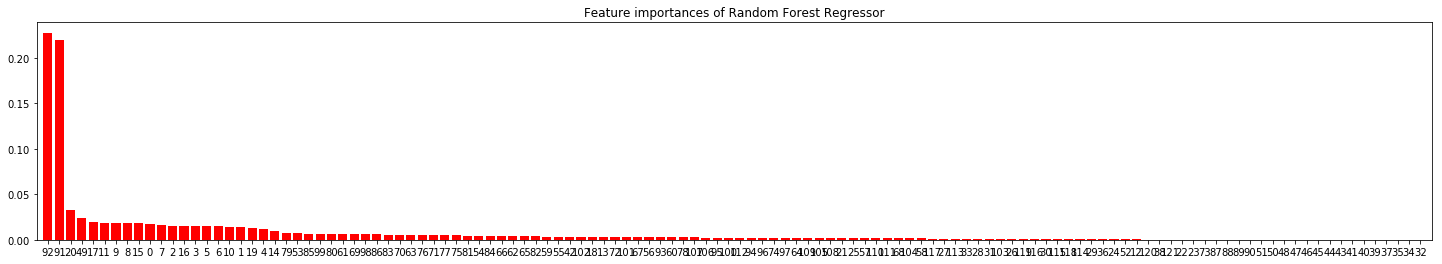

In [168]:
# Print the feature ranking
print("Feature ranking:")

i = 0
for feature in train:
    print (i, feature)
    i += 1
    
plot_importances(rfr, "Random Forest Regressor")

In [175]:
train.iloc[:,0:21]

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees
0,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0
2,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0
6,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0
8,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0
9,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0
10,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0
12,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0
13,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0
15,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0
16,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,29.97,...,29.90,10.0,10.0,6.0,23.0,12.0,30.0,0.000,6.0,277.0


In [205]:
def pca(X):  
    # normalize the features
    X = (X - X.mean()) / X.std()

    # compute the covariance matrix
    X = np.matrix(X)
    cov = (X.T * X) / X.shape[0]

    # perform SVD
    U, S, V = np.linalg.svd(cov)

    return U, S, V

U, S, V = pca(train.iloc[:,0:21])  
U, S, V 

(matrix([[ -1.81952540e-01,   2.96077041e-01,   3.07755476e-01,
            1.72866698e-01,   1.05352815e-01,   1.43683908e-01,
            1.47531626e-01,   8.02714893e-03,  -1.05536642e-01,
            6.63749179e-02,   1.44157244e-01,   4.66712888e-02,
            7.40519665e-02,   1.98848848e-01,   4.38986640e-01,
            4.46886986e-01,  -7.59091658e-02,  -3.12923950e-02,
           -2.96480164e-03,  -1.66584678e-01,   4.36595276e-01],
         [ -2.83256468e-01,   2.28182728e-01,   2.32735138e-01,
            5.10155400e-02,   5.39742880e-02,   2.35842655e-01,
            5.57500236e-02,  -6.72442460e-02,   2.37982101e-02,
            2.36261288e-02,   3.83887435e-02,   4.60252678e-02,
           -2.23164718e-02,   1.99421143e-01,  -1.19934411e-01,
            2.73901640e-01,  -4.87379539e-02,   3.77553008e-02,
            2.62906214e-02,   2.78734065e-01,  -7.26767409e-01],
         [ -3.32774993e-01,   9.52142885e-02,   9.66066560e-02,
           -1.00578549e-01,  -2.045237

In [207]:
def project_data(X, U, k):  
    U_reduced = U[:,:k]
    return np.dot(X, U_reduced)

Z = project_data(train.iloc[:,0:21], U, 10)  